In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm import tqdm
import cv2
from sklearn.metrics import recall_score
from tensorflow import keras
from keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


/kaggle/input/multi-outputs-model-v2/multi_outputs_model_V2.h5
/kaggle/input/model-train-prediction/multi_outputs_model_prediction.csv
/kaggle/input/multi-outputs-model-bengali-grapheme/multi_outputs_model.h5
/kaggle/input/multi-outputs-model-bengali-grapheme/submission.csv
/kaggle/input/bengaliai-cv19/test_image_data_2.parquet
/kaggle/input/bengaliai-cv19/test_image_data_3.parquet
/kaggle/input/bengaliai-cv19/test_image_data_0.parquet
/kaggle/input/bengaliai-cv19/train.csv
/kaggle/input/bengaliai-cv19/test_image_data_1.parquet
/kaggle/input/bengaliai-cv19/class_map.csv
/kaggle/input/bengaliai-cv19/train_image_data_3.parquet
/kaggle/input/bengaliai-cv19/train_image_data_2.parquet
/kaggle/input/bengaliai-cv19/test.csv
/kaggle/input/bengaliai-cv19/sample_submission.csv
/kaggle/input/bengaliai-cv19/train_image_data_1.parquet
/kaggle/input/bengaliai-cv19/train_image_data_0.parquet


# Targets loading

In [2]:
#CSV loading
class_map = pd.read_csv("../input/bengaliai-cv19/class_map.csv")
train_target = pd.read_csv("../input/bengaliai-cv19/train.csv")
train_target.set_index(keys='image_id', drop=True, inplace=True)

In [3]:
display(train_target)

,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
image_id,,,,
Train_0,15,9,5,ক্ট্রো
Train_1,159,0,0,হ
Train_2,22,3,5,খ্রী
Train_3,53,2,2,র্টি
Train_4,71,9,5,থ্রো
...,...,...,...,...
Train_200835,22,7,2,র্খে
Train_200836,65,9,0,ত্তো
Train_200837,2,1,4,অ্যা


In [4]:
display(class_map)

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই
...,...,...,...
181,consonant_diacritic,2,র্
182,consonant_diacritic,3,র্য
183,consonant_diacritic,4,্য
184,consonant_diacritic,5,্র


# Resizing function

Resizing and cropping function that will be used on data for preprocessing befor inference.

In [5]:
HEIGHT = 137
WIDTH = 236
CROP_SIZE = 80

In [6]:
def crop_and_resize_images(df, resized_df, resize_size = CROP_SIZE):
    cropped_imgs = {}
    for img_id in tqdm(range(df.shape[0])):
        img = resized_df[img_id]
        _, thresh = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
        
        idx = 0 
        ls_xmin = []
        ls_ymin = []
        ls_xmax = []
        ls_ymax = []
        for cnt in contours:
            idx += 1
            x,y,w,h = cv2.boundingRect(cnt)
            ls_xmin.append(x)
            ls_ymin.append(y)
            ls_xmax.append(x + w)
            ls_ymax.append(y + h)
        xmin = min(ls_xmin)
        ymin = min(ls_ymin)
        xmax = max(ls_xmax)
        ymax = max(ls_ymax)

        roi = img[ymin:ymax,xmin:xmax]
        resized_roi = cv2.resize(roi, (resize_size, resize_size))
        cropped_imgs[df.image_id[img_id]] = resized_roi.reshape(-1)
        
    resized = pd.DataFrame(cropped_imgs).T.reset_index()
    resized.columns = resized.columns.astype(str)
    resized.rename(columns={'index':'image_id'},inplace=True)
    return resized #out_df

# model loading

In [7]:
model = load_model('/kaggle/input/multi-outputs-model-v2/multi_outputs_model_V2.h5')

# inference loop

Making predictions from train data (containing validation data used for training).

In [8]:
root_preds = []
vowel_preds = []
consonant_preds = []

for i in range(4):    
    # Data loading
    test_df = pd.read_parquet(f'/kaggle/input/bengaliai-cv19/train_image_data_{i}.parquet')
    
    #reshaping images as array
    resized = test_df.iloc[:, 1:32333].values.reshape(-1, HEIGHT, WIDTH)
    
    # cropping to character and resizing to 80x80 as dataframe
    cropped_df = crop_and_resize_images(test_df, resized, CROP_SIZE)
    
    # reshaping to numpy 80x80 array 
    test_index = cropped_df['image_id'].values.tolist()
    X_test = cropped_df.iloc[:,1:].values.reshape(-1, CROP_SIZE, CROP_SIZE, 1)/255
    
    del test_df
    del resized
    del cropped_df

    # Making prediction
    preds = model.predict(X_test, verbose=1, batch_size=256)
    
    # Keeping the class with highest probablity for the 3 targets
    root_preds.extend(preds[0].argmax(axis=1).tolist())
    vowel_preds.extend(preds[1].argmax(axis=1).tolist())
    consonant_preds.extend(preds[2].argmax(axis=1).tolist())
        
    del X_test
    del preds
    gc.collect

100%|██████████| 50210/50210 [00:52<00:00, 954.22it/s]


50210/50210 [==============================] - 756s 15ms/step


100%|██████████| 50210/50210 [00:52<00:00, 954.47it/s]


50210/50210 [==============================] - 760s 15ms/step


100%|██████████| 50210/50210 [00:52<00:00, 961.27it/s]


50210/50210 [==============================] - 760s 15ms/step


100%|██████████| 50210/50210 [00:53<00:00, 945.16it/s]


50210/50210 [==============================] - 759s 15ms/step


In [9]:
preds_df = pd.DataFrame(list(zip(root_preds, vowel_preds,consonant_preds)),
                        columns =['grapheme_root_preds', 'vowel_diacritic_preds',
                                 'consonant_diacritic_preds'], index=train_target.index)

In [10]:
preds_df.to_csv('multi_outputs_model_prediction.csv')

# Error analysis

As  we don't have access to test data, model error analysis will be made on train data.  
Inside those train datasets some samples were still not used for model training and only for validation, so this will still give some insights on error made by the model.

## Make predictions

loading predictions predictions from train data (containing validation data used for training).

In [11]:
predictions = pd.read_csv('/kaggle/input/model-train-prediction/multi_outputs_model_prediction.csv',
                          index_col='image_id')
predictions.columns=['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']

In [12]:
display(predictions)

,grapheme_root,vowel_diacritic,consonant_diacritic
image_id,,,
Train_0,15,9,5
Train_1,159,0,0
Train_2,22,3,5
Train_3,53,2,2
Train_4,71,9,5
...,...,...,...
Train_200835,22,7,2
Train_200836,65,9,0
Train_200837,2,1,4


## Filter false predictions

Creation of a dataframe containing only grapheme components that were wrongly classified.  
Ground truth columns are followed by 'true' and predictions by 'pred'.

In [13]:
# Checking and keeping only rows that are differents in ground truth and predictions
ground_truth = train_target.loc[:,['grapheme_root','vowel_diacritic', 'consonant_diacritic']]
false_preds_filter = (predictions != ground_truth).any(1)
false_preds = ground_truth.merge(predictions,on='image_id', suffixes=('_true', '_pred'))[false_preds_filter]

In [14]:
display(false_preds)

,grapheme_root_true,vowel_diacritic_true,consonant_diacritic_true,grapheme_root_pred,vowel_diacritic_pred,consonant_diacritic_pred
image_id,,,,,,
Train_7,139,3,0,139,3,2
Train_61,54,0,0,53,0,5
Train_304,63,0,0,25,0,0
Train_381,23,0,5,23,7,5
Train_532,72,0,2,72,0,5
...,...,...,...,...,...,...
Train_200530,23,0,5,23,7,5
Train_200587,79,1,0,55,1,0
Train_200661,43,0,2,56,0,2


## Error type analysis

Analysis of wich component(s) is the source of error.  
The error can be :
- Grapheme root only
- vowel diacritic only
- consonant diacritic only
- multiples sources (two or more errors sources)

In [15]:
def error_type(df):
    # Detect for every rows if there is an error (1) or not (0) in each target 
    root_error_flag = (df['grapheme_root_true'] - df['grapheme_root_pred']) != 0
    root_error_flag.replace({True: 1, False: 0}, inplace=True)
    vowel_error_flag = (df['vowel_diacritic_true'] - df['vowel_diacritic_pred']) != 0
    vowel_error_flag.replace({True: 1, False: 0}, inplace=True)
    consonant_error_flag = (df['consonant_diacritic_true'] - df['consonant_diacritic_pred']) != 0
    consonant_error_flag.replace({True: 1, False: 0}, inplace=True)
    
    # Detect for every rows if there is an error in multiple targets
    multiple_error_flag = (root_error_flag + vowel_error_flag + consonant_error_flag) > 1
    
    # Detect is there is only one error type in a row
    root_error = (root_error_flag==1) & (multiple_error_flag!=1)
    vowel_error = (vowel_error_flag==1) & (multiple_error_flag!=1)
    consonant_error = (consonant_error_flag==1) & (multiple_error_flag!=1)
    
    # Create a dictionnary contraining the count for every type of error
    error_type_results = {'root': root_error.sum()/root_error.shape[0]*100,
                          'vowel': vowel_error.sum()/vowel_error.shape[0]*100,
                          'consonant': consonant_error.sum()/consonant_error.shape[0]*100,
                         'multi': multiple_error_flag.sum()/multiple_error_flag.shape[0]*100}
    return error_type_results

In [16]:
error_type = error_type(false_preds)

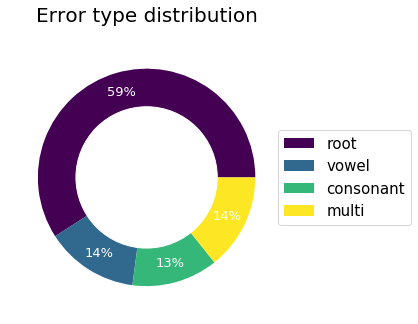

In [17]:
# Plotting error types repartition
fig, ax = plt.subplots(figsize=(8,5))
col = cm.get_cmap('viridis', 4)
ax.pie(error_type.values(), autopct='%1.0f%%', pctdistance=0.82, colors=col.colors, 
       textprops=dict(color="w", fontsize=13))
ax.legend(labels=error_type.keys(), loc='right', bbox_to_anchor=(1.5, 0.5), fontsize=15)
ax.set_title('Error type distribution', pad=20, fontsize=20)
s_circle=plt.Circle( (0,0), 0.65, color='white')
ax.add_patch(s_circle)

Around 60% of error is due to root only error. The remainings error are evenly split between vowel, consonnant and multi-components errors.  
Working on improving root classification seems to be the key to imrove overall model performance.

## Error by class for each component

Here we'll have a look at error distribution over classes for each component.
The results will be displayed as % of total number of errors.  
It's interesting to have a look at this from two perspectives : missclassified ground truth and which components were predicted while giving wrong results.  
The first can highlight if some component class in particular is difficult to classify and the other one can show is maybe one class is predicted for most errors.

In [18]:
def plot_error_component(df, component, ref):
    
    # Checking if there is an error on specified component
    error_flag = (df[component+'_true'] - df[component+'_pred']) != 0
    # Filtering df to keep only row with error on specified component
    filtered_false_preds = df.loc[error_flag]

    # Plotting fraction of overall error for each class
    ax, fig = plt.subplots(figsize=(40,12))
    ax = sns.barplot(x=filtered_false_preds[component+'_'+ref].value_counts().index,
                     y=filtered_false_preds[component+'_'+ref].value_counts().values/filtered_false_preds.shape[0]*100)
    ax.set_title('Missclassified ' + component+'_'+ref, fontsize=30, pad=15)
    ax.set_xlabel(component, fontsize=30, labelpad=20)
    ax.set_ylabel('Fraction of total error (%)', fontsize=30, labelpad=20)
    plt.xticks(fontsize=10, rotation=90);
    plt.yticks(fontsize=25);

## Missclassified ground truth per class for each component

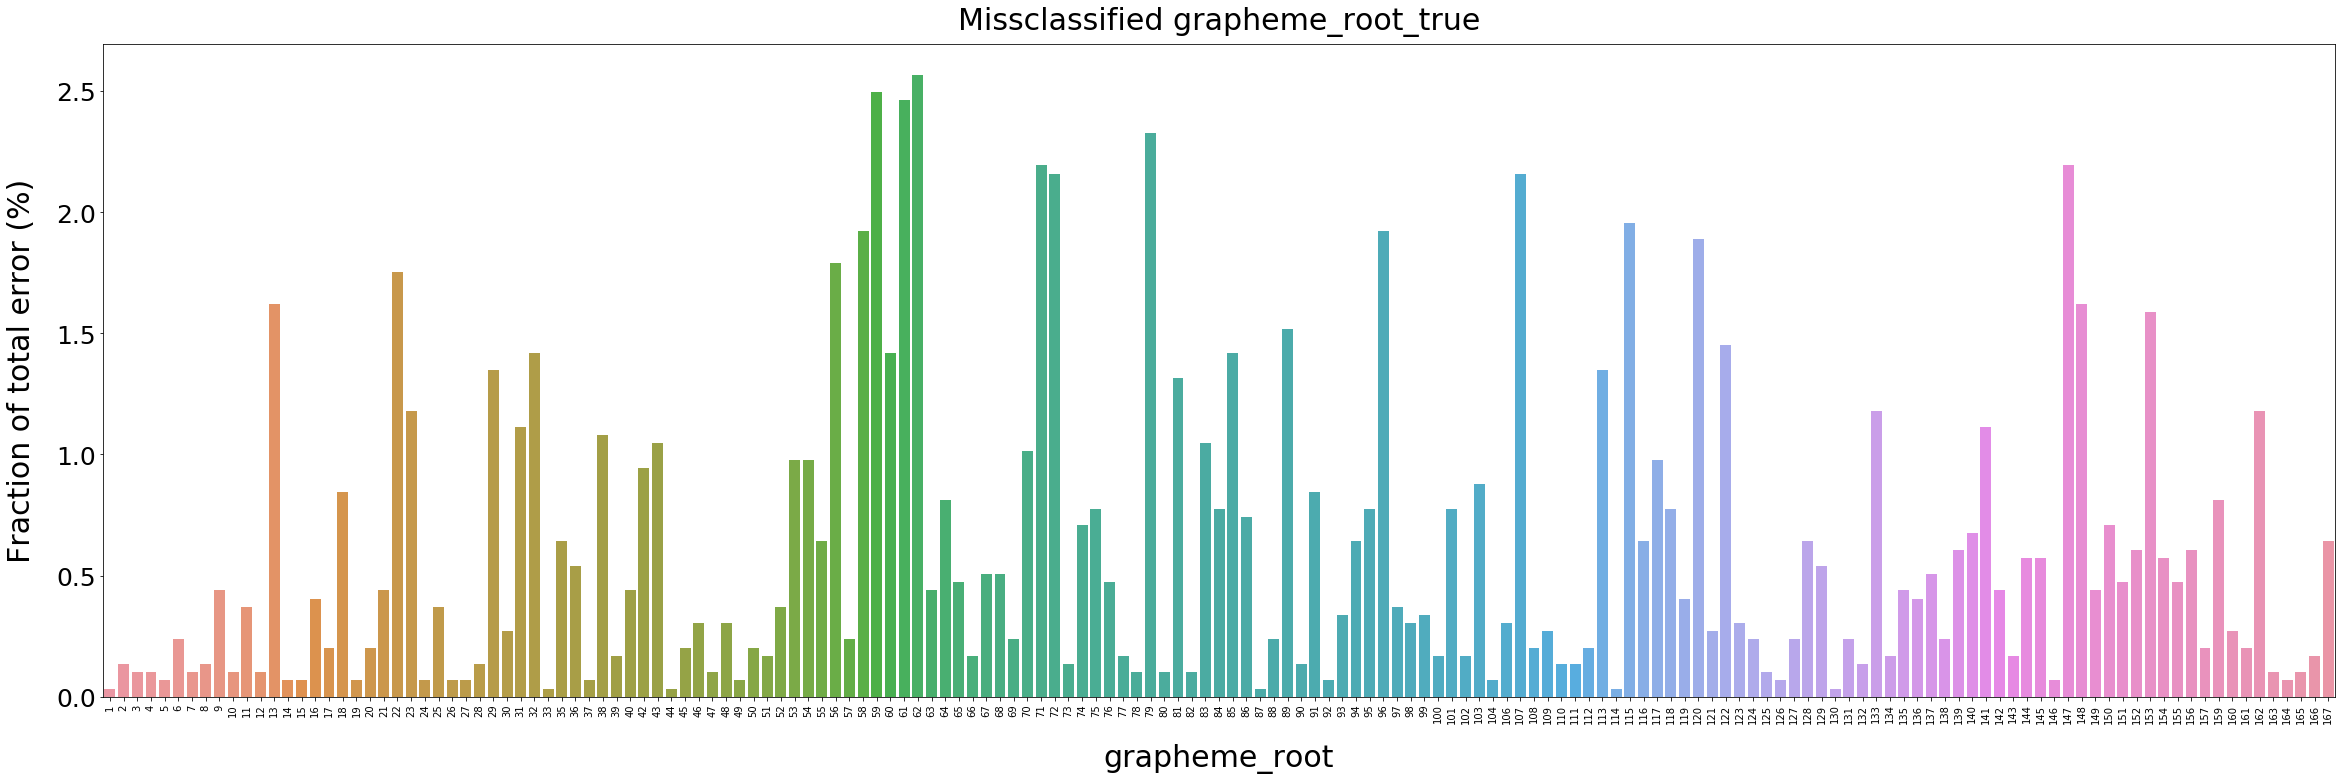

In [19]:
plot_error_component(false_preds,'grapheme_root', 'true')

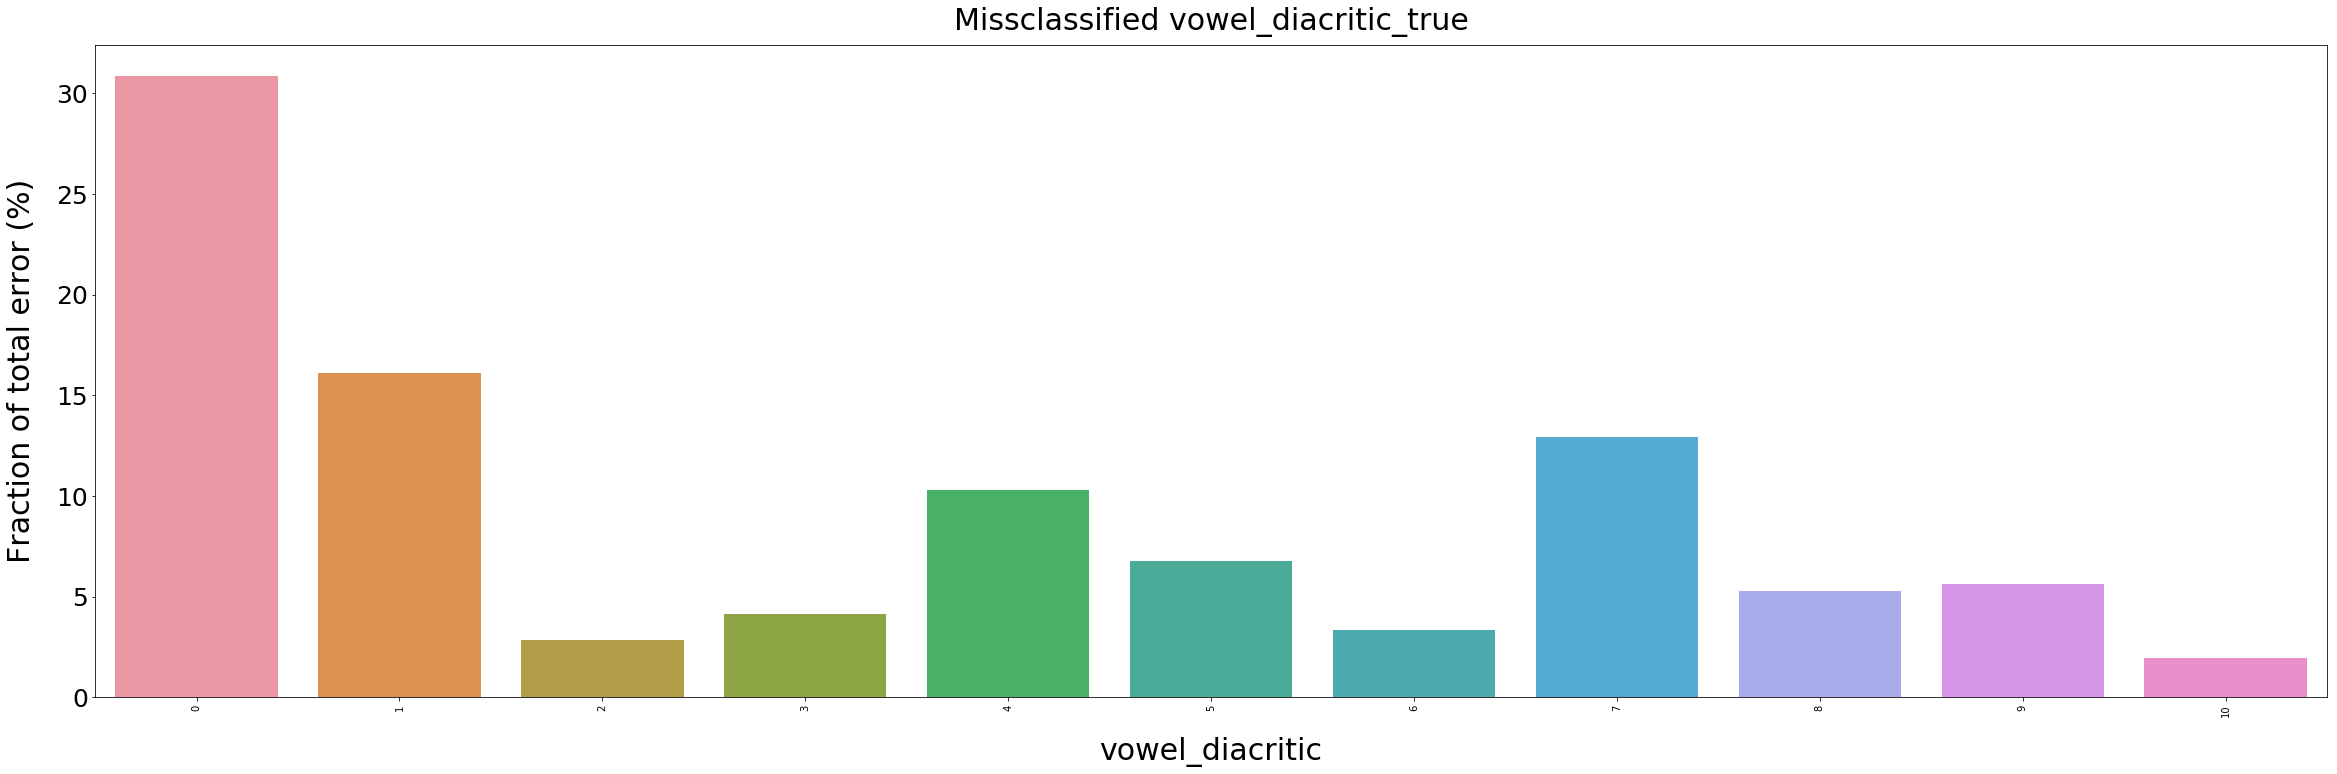

In [20]:
plot_error_component(false_preds,'vowel_diacritic', 'true')

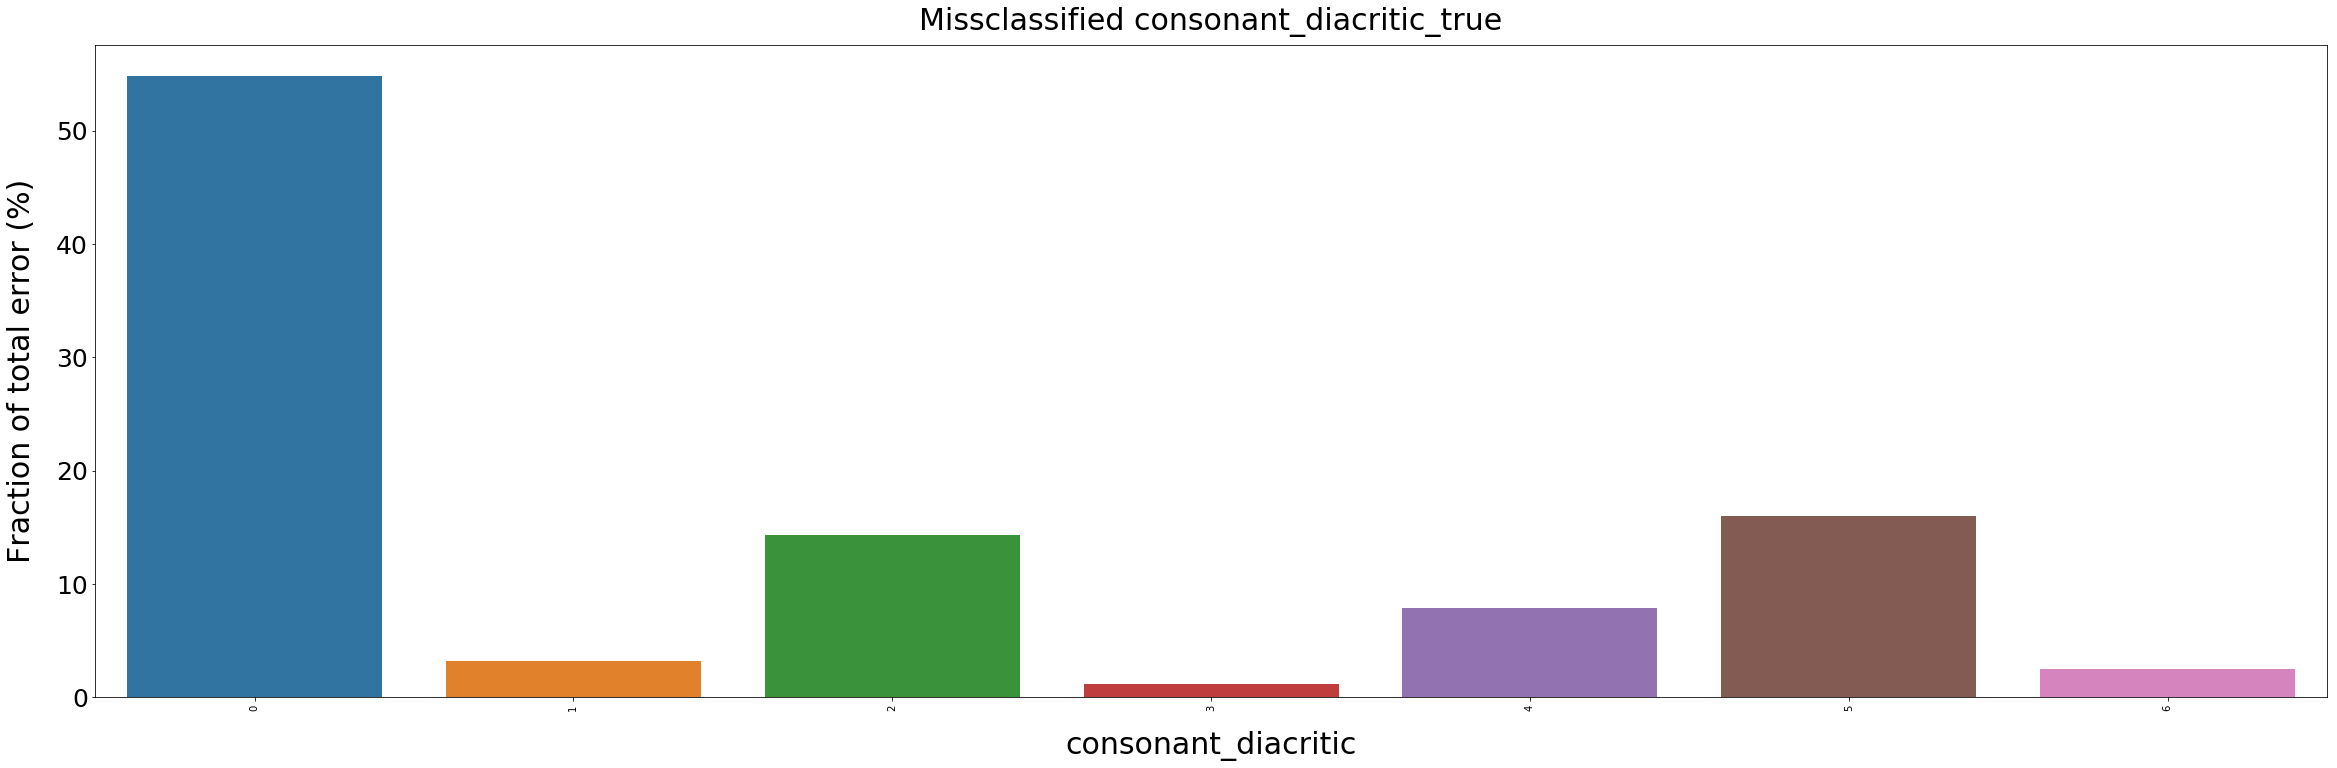

In [21]:
plot_error_component(false_preds,'consonant_diacritic', 'true')

## Wrongly predicted class for each component

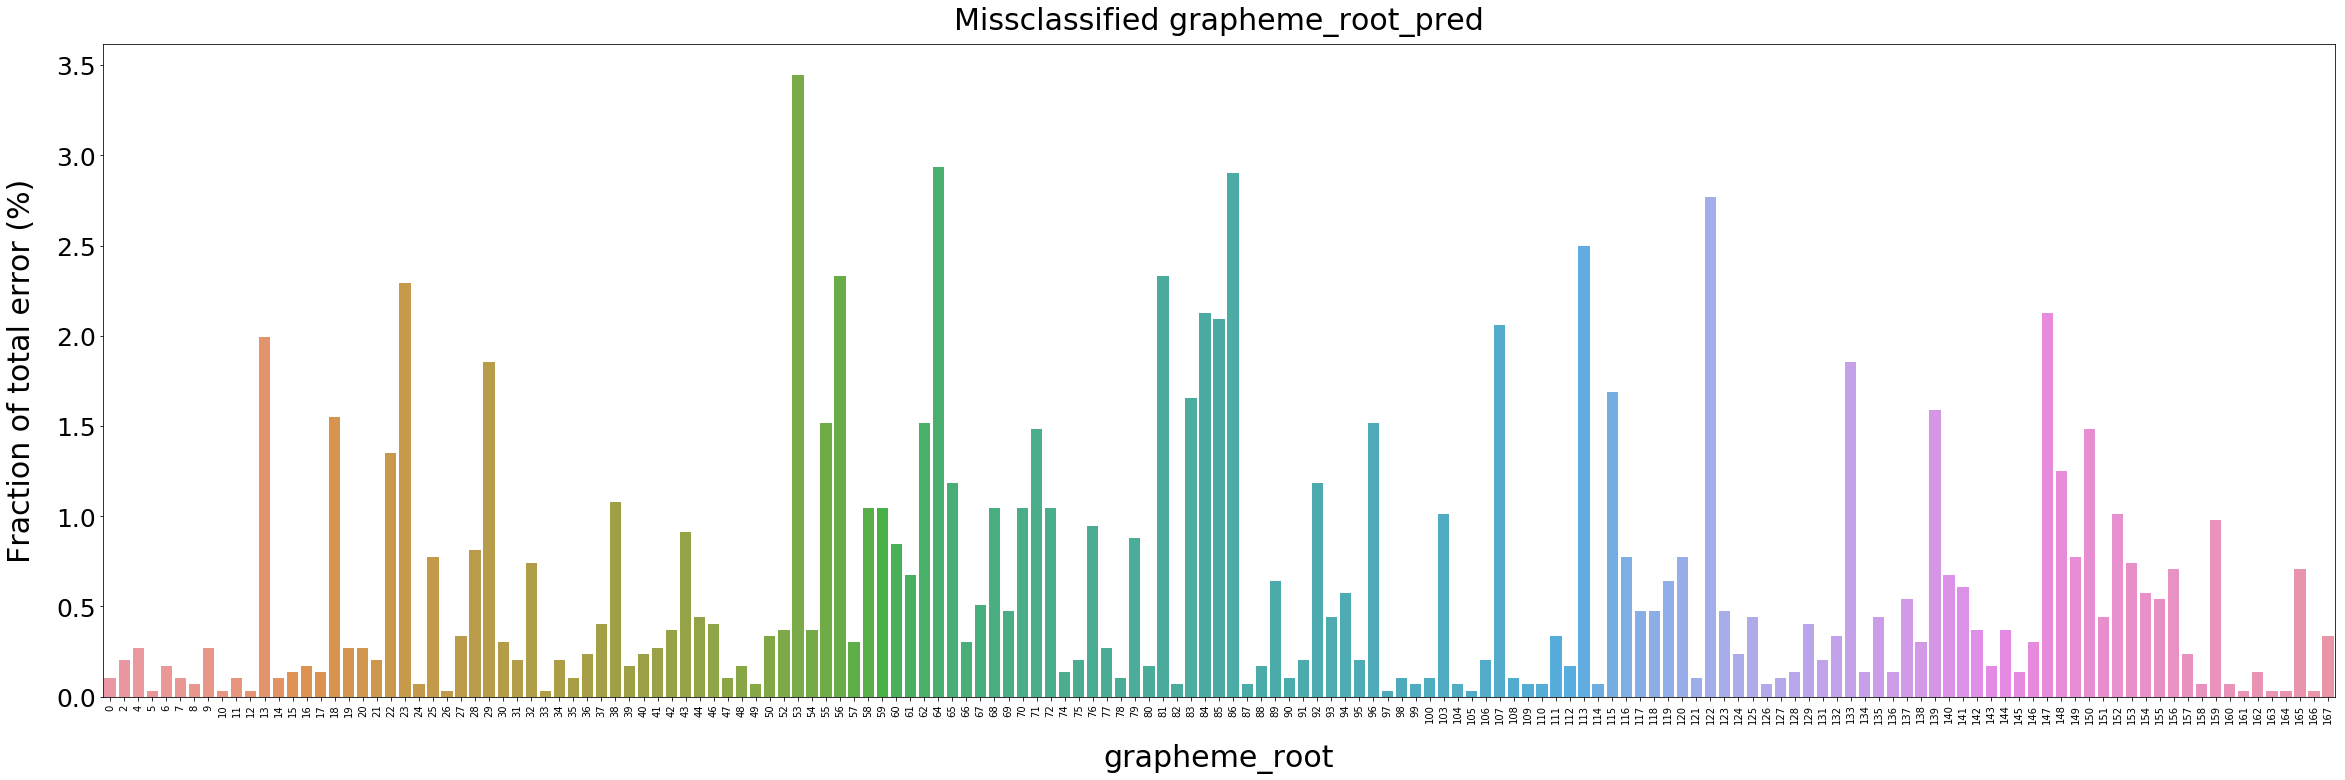

In [22]:
plot_error_component(false_preds,'grapheme_root', 'pred')

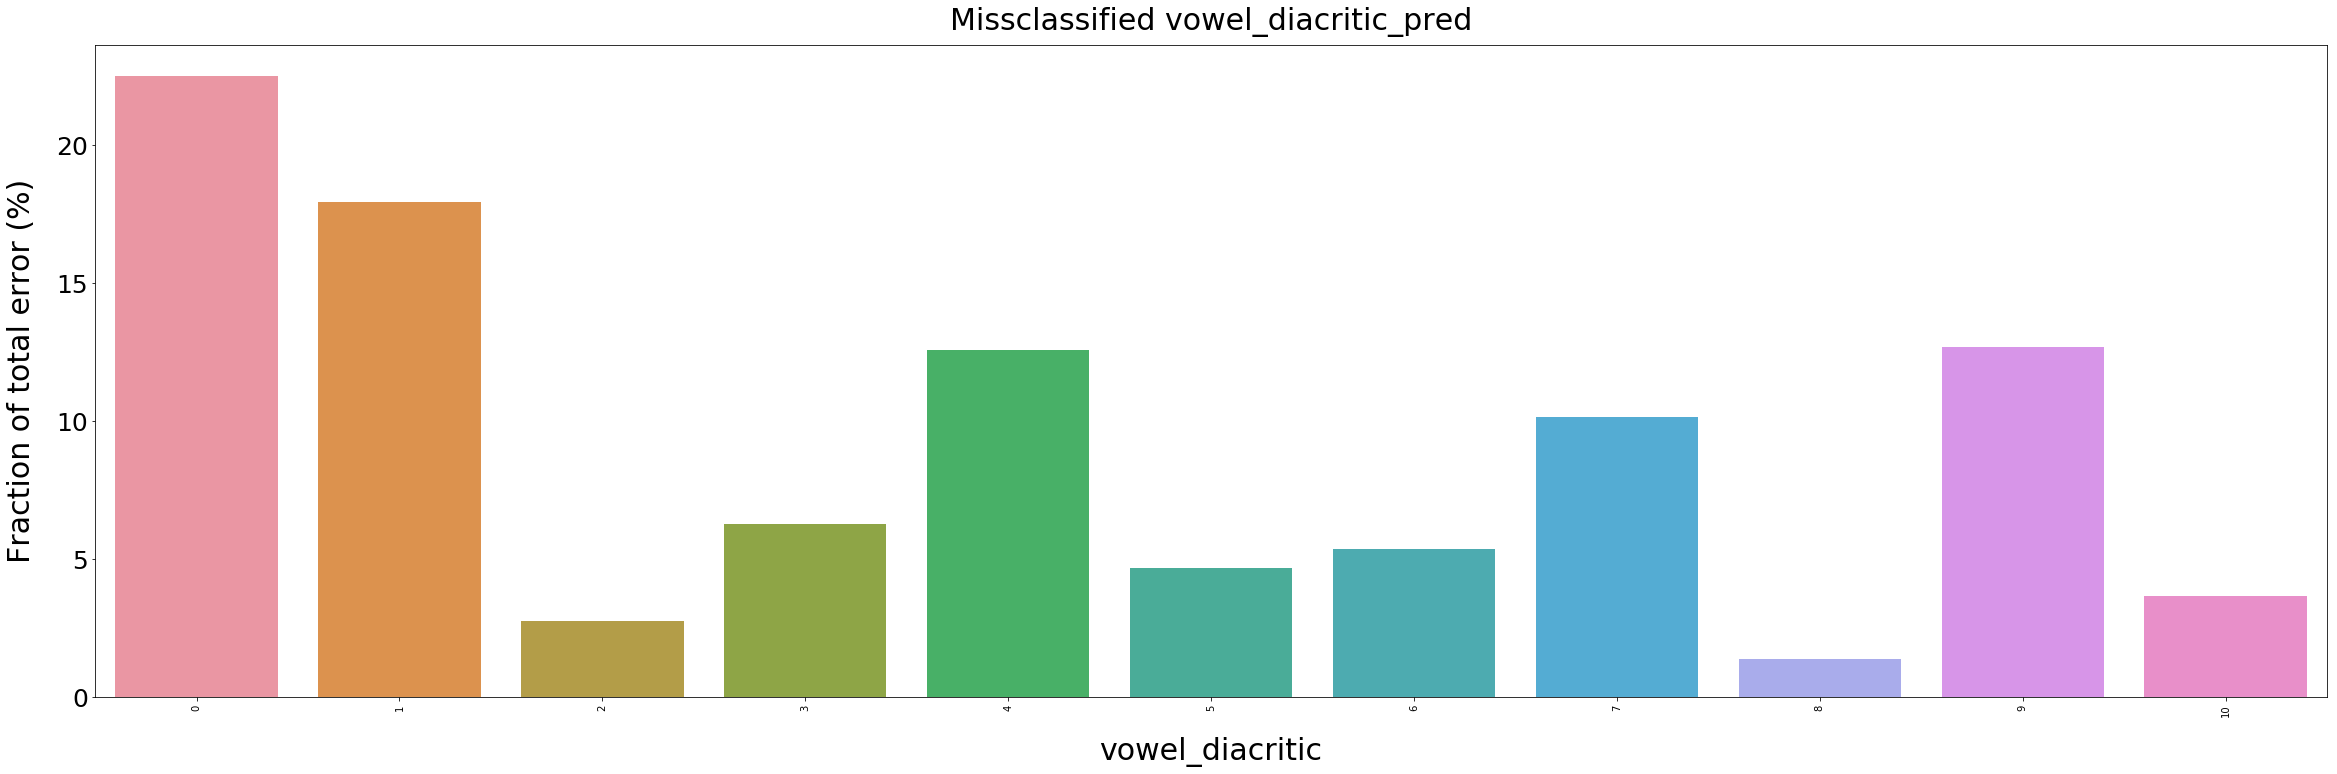

In [23]:
plot_error_component(false_preds,'vowel_diacritic', 'pred')

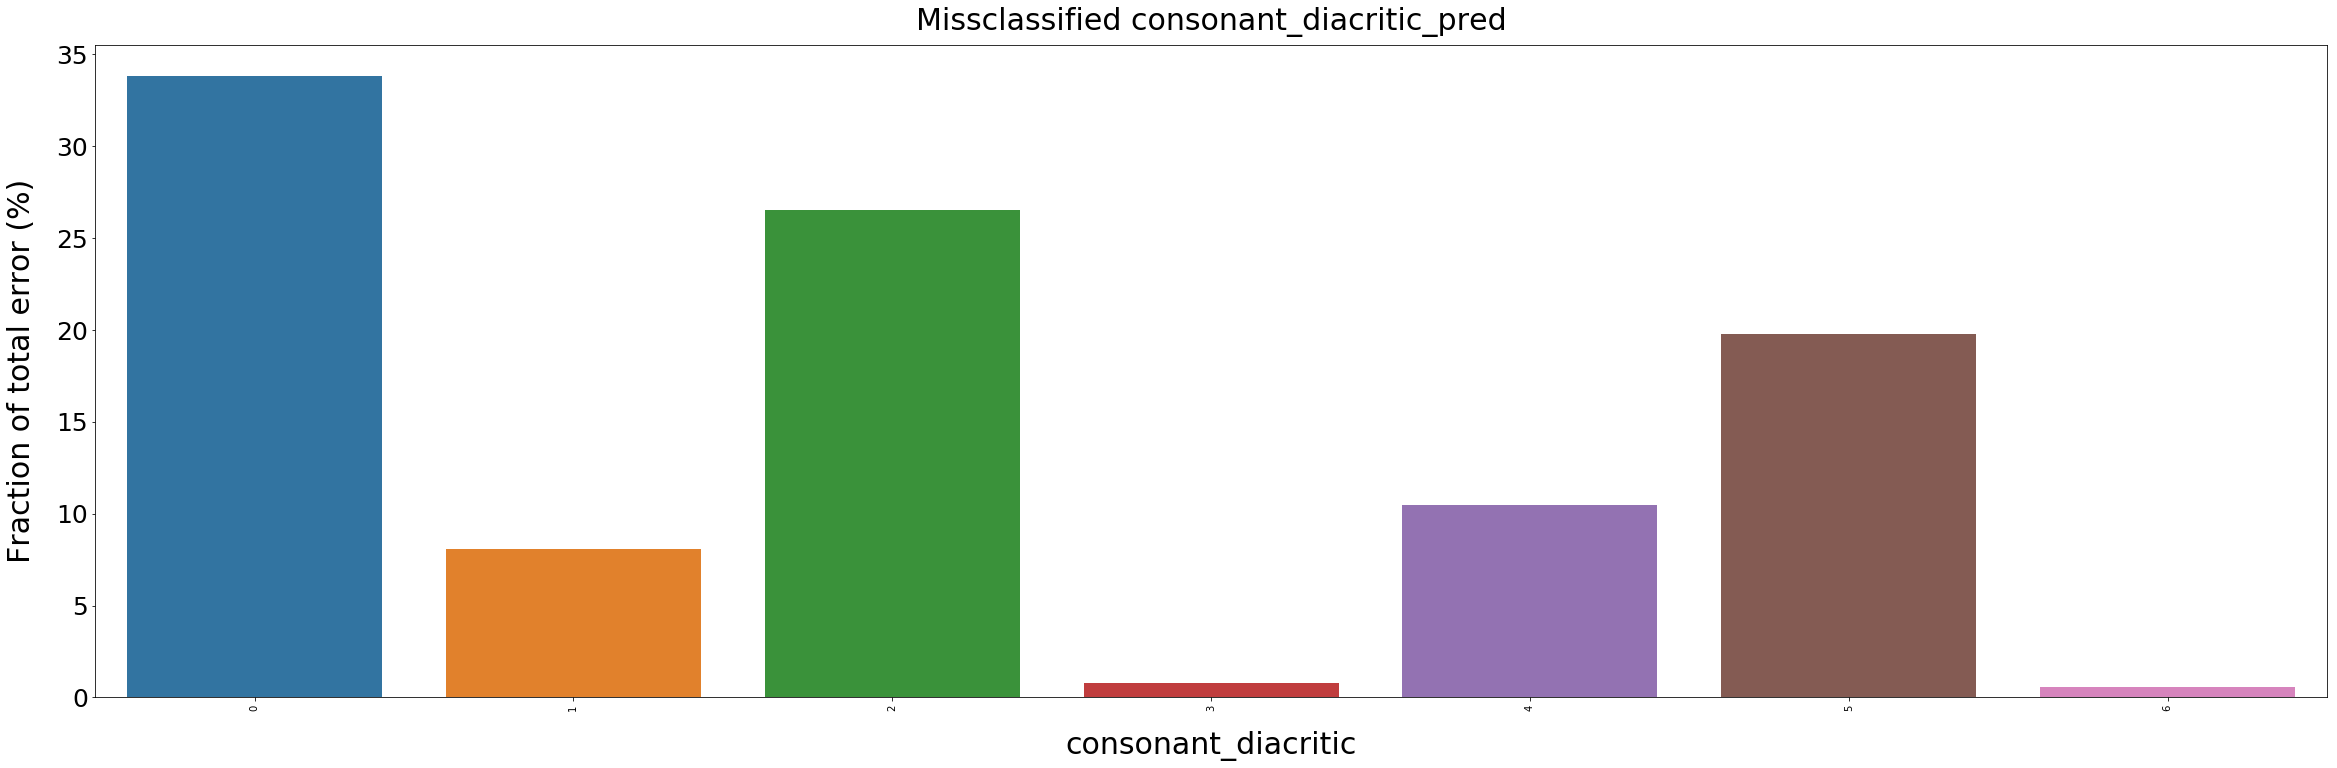

In [24]:
plot_error_component(false_preds,'consonant_diacritic', 'pred')

This did not gave much more informations.
For vowel and consonant, error rates are mostly following samples distribution (more samples => More error), so it does not seems that one is more difficult to classify than another one.
It seems to be the same for root. Maybe a better performing model could highlight some specifics components that are the cause of a majority of errors.